##**DATA PREPARATION**

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.0 MB/s eta 0:00:00


In [ ]:
# import library

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', 250)

In [ ]:
# import dataset

from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Skripsi/Dataset/stunting.csv"
df = pd.read_csv(path)

Mounted at /content/drive


###**PREPROCESSING**

In [ ]:
# dataset information

total_outliers = 0
total_points = 0

for col in df.select_dtypes(include=['int64', 'float64']).columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower) | (df[col] > upper)].shape[0]
    total_outliers += outliers
    total_points += df.shape[0]

print(f'''
Dataset Information Summary
-------------------------------
Columns with missing values     = {df.isnull().any().sum()} : {df.columns[df.isna().any()].tolist()}
Rows with missing values        = {df.isnull().sum().sum()}
Percentage Missing              = {(df.isnull().sum().sum() / np.prod(df.shape)) * 100:.2f}%
Total Outliers Detected         = {total_outliers}
Percentage of Outlier Values    = {(total_outliers / total_points) * 100:.2f}%
Total Columns                   = {df.shape[1]}
Total Rows                      = {df.shape[0]}
''')


Dataset Information Summary
-------------------------------
Columns with missing values     = 0 : []
Rows with missing values        = 0
Percentage Missing              = 0.00%
Total Outliers Detected         = 46
Percentage of Outlier Values    = 0.02%
Total Columns                   = 4
Total Rows                      = 120999



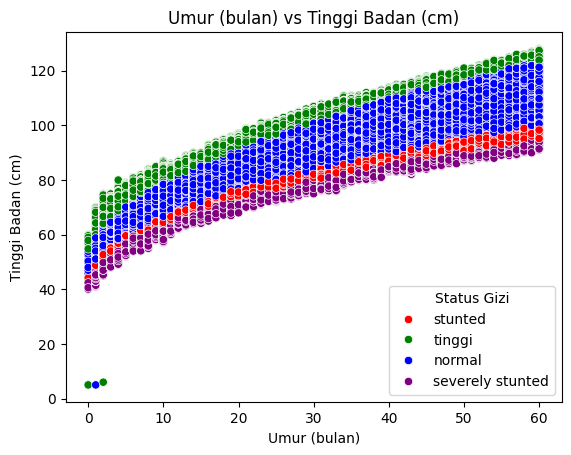

In [ ]:
# Dataset Visualization

colors = {
    'stunted': 'red',
    'severely stunted': 'purple',
    'tinggi': 'green',
    'normal': 'blue'
}
sns.scatterplot(data=df, x='Umur (bulan)', y='Tinggi Badan (cm)', hue='Status Gizi', palette=colors)
plt.title('Umur (bulan) vs Tinggi Badan (cm)')
plt.show()

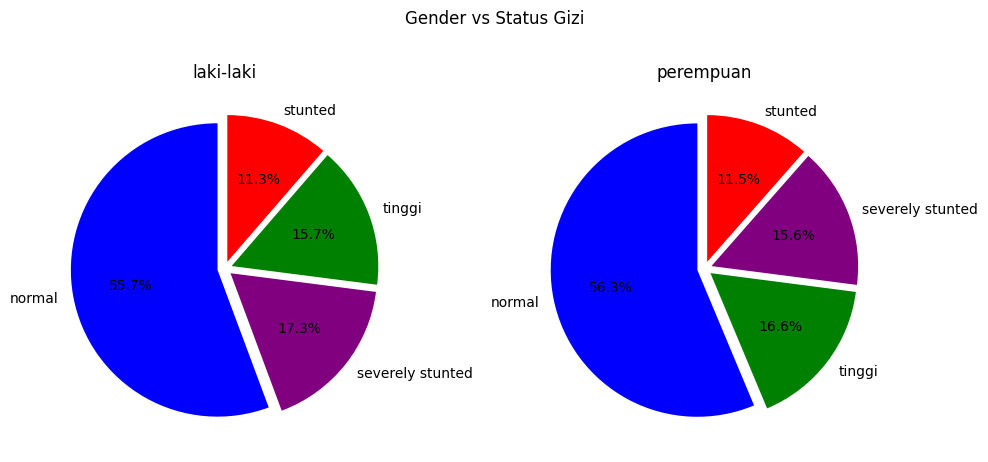

In [ ]:
# Pie Chart Status Gizi/Gender

male_counts = df[df['Jenis Kelamin'] == 'laki-laki']['Status Gizi'].value_counts()
female_counts = df[df['Jenis Kelamin'] == 'perempuan']['Status Gizi'].value_counts()
data = [male_counts, female_counts]
titles = ['laki-laki', 'perempuan']

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i in range(2):
    pie_colors = [colors[label] for label in data[i].index]
    axes[i].pie(data[i], labels=data[i].index, autopct='%1.1f%%', startangle=90, explode=[0.05]*len(data[i]), colors=pie_colors)
    axes[i].set_title(titles[i])

plt.suptitle("Gender vs Status Gizi")
plt.tight_layout()
plt.show()

In [ ]:
# remove outliers

def find_anomalies(data, column):
    q1, q3 = data.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    count = ((data < lower) | (data > upper)).sum()
    return pd.DataFrame({
        'Column': [column],
        'IQR': [iqr],
        'Lower Bound': [lower],
        'Upper Bound': [upper],
        'Outliers': [count]
    })

# Ringkasan outlier per kolom
df_outliers = pd.concat(
    [find_anomalies(df[col], col) for col in df.select_dtypes(include=['int64', 'float64']).columns],
    ignore_index=True
)

print("Ringkasan Outlier per Kolom")
print(df_outliers)

# Hapus outlier dari dataset
for _, row in df_outliers.iterrows():
    df = df[(df[row['Column']] >= row['Lower Bound']) & (df[row['Column']] <= row['Upper Bound'])]

print(f"\nTotal outliers removed: {df_outliers['Outliers'].sum()}")

Ringkasan Outlier per Kolom
              Column   IQR  Lower Bound  Upper Bound  Outliers
0       Umur (bulan)  30.0        -30.0         90.0         0
1  Tinggi Badan (cm)  24.2         40.7        137.5        46

Total outliers removed: 46


In [ ]:
# label encoding

from sklearn.preprocessing import LabelEncoder

le_status = LabelEncoder()
df['Status Gizi'] = le_status.fit_transform(df['Status Gizi'])
df['Jenis Kelamin'] = LabelEncoder().fit_transform(df['Jenis Kelamin'])
class_labels = le_status.classes_

In [ ]:
# sampling every class

df_sampled = (
    df.groupby(['Status Gizi', 'Jenis Kelamin'], group_keys=False)
    .apply(lambda x: x.sample(min(500, len(x)), random_state=42))
    .reset_index(drop=True)
)
print(f"Jumlah total data hasil sampling: {df_sampled.shape[0]}")

Jumlah total data hasil sampling: 4000


In [ ]:
X_sampled = df_sampled.drop(columns=['Status Gizi'])
y_sampled = df_sampled['Status Gizi']

In [ ]:
# Menampilkan 5 baris pertama
head = df_sampled.head(5)

# Menampilkan 5 baris tengah
mid_index = len(df_sampled) // 2
middle = df_sampled.iloc[mid_index - 2 : mid_index + 3]

# Menampilkan 5 baris terakhir
tail = df_sampled.tail(5)

# Gabungkan ketiganya
sample_mix = pd.concat([head, middle, tail])
sample_mix

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
0,38,0,93.0,0
1,42,0,109.6,0
2,50,0,99.1,0
3,43,0,92.8,0
4,32,0,92.7,0
1998,58,1,91.1,1
1999,46,1,86.4,1
2000,18,0,74.3,2
2001,38,0,88.7,2
2002,23,0,79.1,2


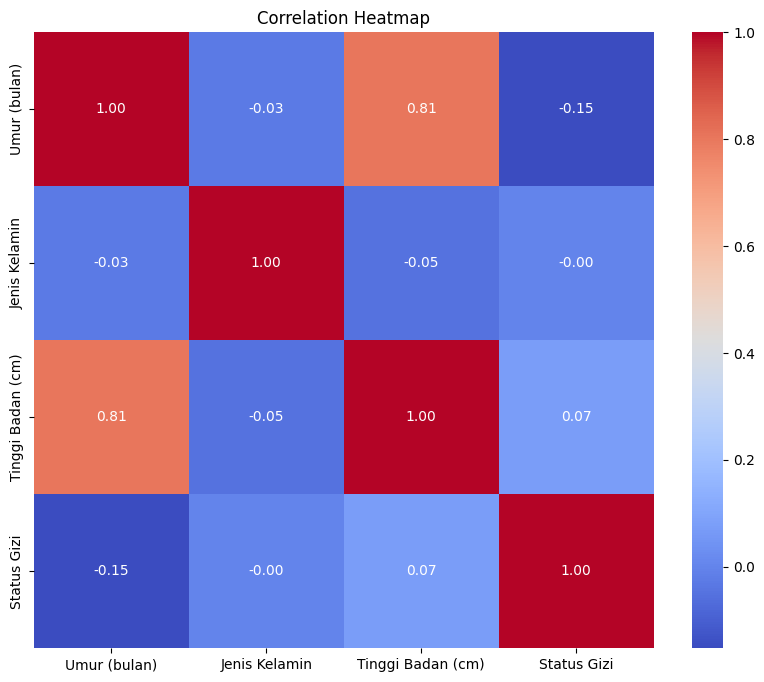

In [ ]:
# Heatmap Correlation

plt.figure(figsize=(10, 8))
sns.heatmap(df_sampled.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

##**MODELING**

In [ ]:
# training & validation data

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import precision_score, recall_score, f1_score

# Definisi model
# --- Pastikan target berupa array numpy ---
y_sampled = np.array(y_sampled)

# --- Deteksi jumlah kelas (otomatis binary atau multiclass) ---
num_classes = len(np.unique(y_sampled))

# --- Model definitions (AMAN, SIMPEL, SEIMBANG) ---
models = [
    XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        objective='multi:softmax', #'binary:logistic' if num_classes == 2 else 'multi:softmax',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    ),

    LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        objective='multiclass', #'binary' if num_classes == 2 else 'multiclass',
        num_class=num_classes if num_classes > 2 else None,
        random_state=42
    ),

    CatBoostClassifier(
        iterations=500,
        learning_rate=0.05,
        depth=6,
        l2_leaf_reg=1.0,
        loss_function='MultiClass', #'Logloss' if num_classes == 2 else 'MultiClass',
        random_seed=42,
        verbose=False
    )
]


model_names = ["XGBoost", "LightGBM", "CatBoost"]
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Dictionary untuk menyimpan hasil evaluasi
metrics = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1': [],
    'y_pred_cv': []  # Disimpan untuk evaluasi lanjutan
}

# Loop Training & Evaluasi
for model, name in zip(models, model_names):
    y_pred_cv = cross_val_predict(model, X_sampled, y_sampled, cv=kfold)
    acc = cross_val_score(model, X_sampled, y_sampled, cv=kfold, scoring='accuracy').mean()
    prec = precision_score(y_sampled, y_pred_cv, average='weighted', zero_division=0)
    rec = recall_score(y_sampled, y_pred_cv, average='weighted', zero_division=0)
    f1 = f1_score(y_sampled, y_pred_cv, average='weighted', zero_division=0)

    # Simpan hasil
    metrics['Model'].append(name)
    metrics['Accuracy'].append(acc)
    metrics['Precision'].append(prec)
    metrics['Recall'].append(rec)
    metrics['F1'].append(f1)
    metrics['y_pred_cv'].append(y_pred_cv)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

##**EVALUATION**


=== XGBoost ===
                  precision    recall  f1-score   support

          normal       0.95      0.88      0.92      1000
severely stunted       0.93      0.92      0.92      1000
         stunted       0.86      0.90      0.88      1000
          tinggi       0.96      0.98      0.97      1000

        accuracy                           0.92      4000
       macro avg       0.92      0.92      0.92      4000
    weighted avg       0.92      0.92      0.92      4000



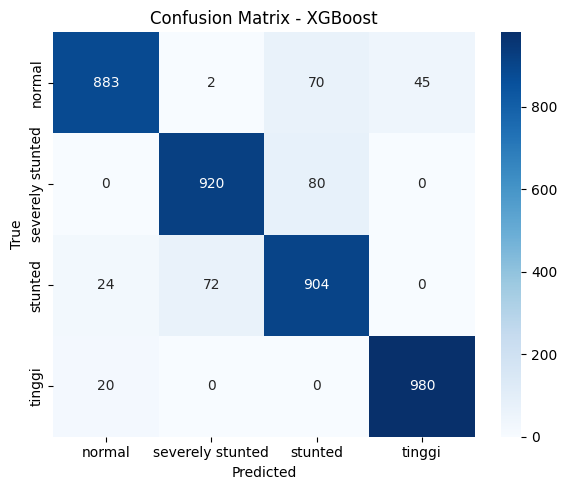


=== LightGBM ===
                  precision    recall  f1-score   support

          normal       0.96      0.91      0.93      1000
severely stunted       0.95      0.93      0.94      1000
         stunted       0.88      0.93      0.90      1000
          tinggi       0.97      0.98      0.97      1000

        accuracy                           0.94      4000
       macro avg       0.94      0.94      0.94      4000
    weighted avg       0.94      0.94      0.94      4000



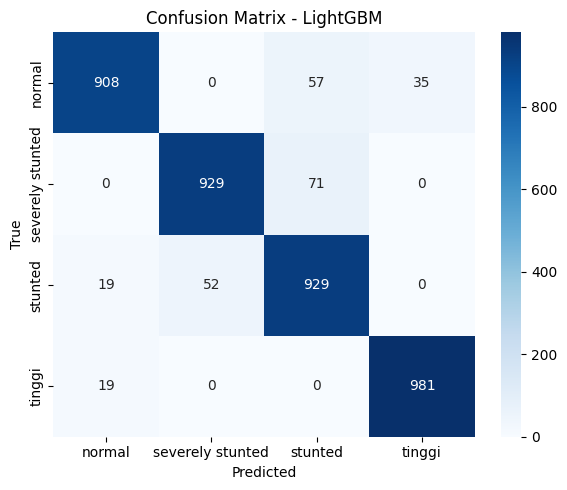


=== CatBoost ===
                  precision    recall  f1-score   support

          normal       0.99      0.87      0.92      1000
severely stunted       0.97      0.94      0.95      1000
         stunted       0.88      0.96      0.92      1000
          tinggi       0.94      0.99      0.97      1000

        accuracy                           0.94      4000
       macro avg       0.94      0.94      0.94      4000
    weighted avg       0.94      0.94      0.94      4000



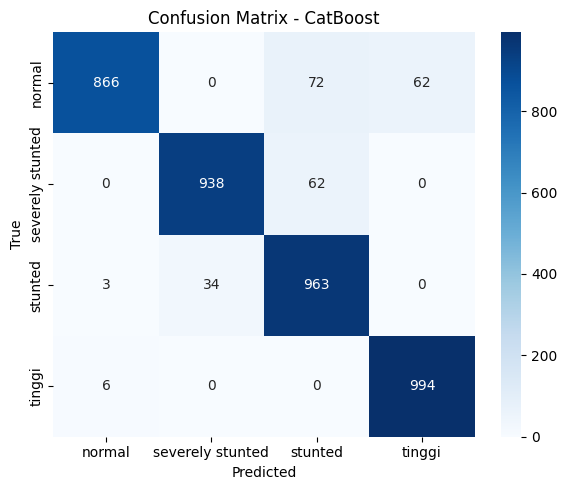

In [ ]:
# visualisation & evaluation
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# DataFrame for Evaluation
eval_df = pd.DataFrame({
    'Model': metrics['Model'],
    'Accuracy': metrics['Accuracy'],
    'Precision': metrics['Precision'],
    'Recall': metrics['Recall'],
    'F1': metrics['F1']
}).sort_values(by='Accuracy', ascending=False)

# Plot Confusion Matrix + Classification Report for each model
for i, name in enumerate(metrics['Model']):
    y_pred = metrics['y_pred_cv'][i]

    print(f"\n=== {name} ===")
    print(classification_report(y_sampled, y_pred, target_names=class_labels, zero_division=0))

    cm = confusion_matrix(y_sampled, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


In [ ]:
# Show Table Comparrison
display(eval_df)

,Model,Accuracy,Precision,Recall,F1
2,CatBoost,0.94025,0.943468,0.94025,0.940108
1,LightGBM,0.93675,0.937819,0.93675,0.936894
0,XGBoost,0.92175,0.922968,0.92175,0.921838


In [ ]:
X = df.drop(columns=['Status Gizi'])
y = df['Status Gizi']

In [ ]:
#Train Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")

X_train: (96762, 3), X_test: (24191, 3)


Classification Report (Final Model):
                  precision    recall  f1-score   support

          normal       1.00      0.90      0.95     13524
severely stunted       0.99      0.96      0.98      4004
         stunted       0.77      0.99      0.86      2768
          tinggi       0.85      1.00      0.92      3895

        accuracy                           0.94     24191
       macro avg       0.90      0.96      0.93     24191
    weighted avg       0.95      0.94      0.94     24191



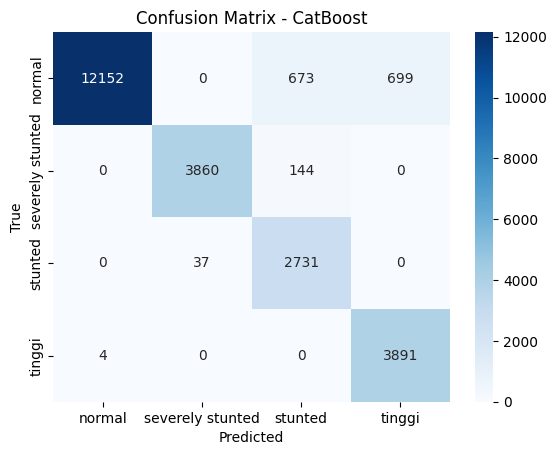

In [ ]:
# final model evaluation (CatBoost)
cb = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=1.0,
    loss_function='MultiClass',
    random_seed=42,
    verbose=False,
    auto_class_weights="Balanced"
    )

cb.fit(X_train, y_train)
y_pred = cb.predict(X_test)

print("Classification Report (Final Model):")
print(classification_report(y_test, y_pred, target_names=class_labels))

cm_test = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - CatBoost")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

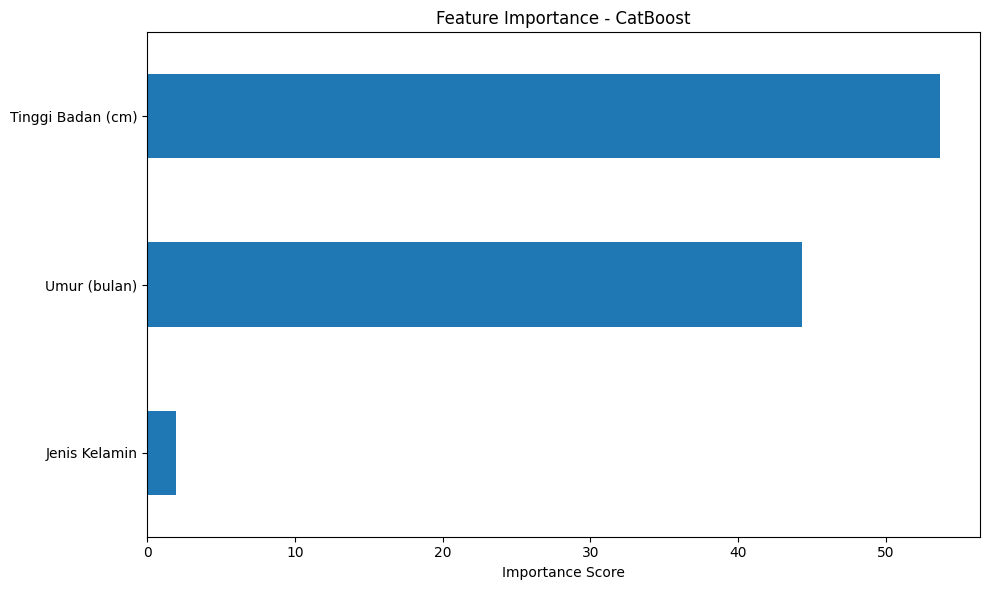

In [ ]:
# feature importance

feature_imp = pd.Series(cb.feature_importances_, index=X.columns).sort_values(ascending=True)
plt.figure(figsize=(10, 6))
feature_imp.plot(kind='barh')
plt.title("Feature Importance - CatBoost")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

###**TESTING**

In [ ]:
jk = input("Jenis Kelamin (laki-laki/perempuan): ").strip().lower()
umur = float(input("Umur (bulan): "))
tinggi = float(input("Tinggi Badan (cm): "))

jk_encoded = 0 if jk == 'laki-laki' else 1

manual_input = pd.DataFrame([{
    'Jenis Kelamin': jk_encoded,
    'Umur (bulan)': umur,
    'Tinggi Badan (cm)': tinggi
}])

pred = cb.predict(manual_input)[0]
pred_label = le_status.inverse_transform([pred])[0]
print(f"\nStatus Gizi: {pred_label}")


##**DEPLOYMENT**



In [ ]:
import joblib
joblib.dump(cb, "model_stunting_final.pkl")